# Lecture des métadonnées d'un nuage de points

Pour débuter, nous allons charger un fichier las/laz.


In [1]:
%%time
import subprocess
import json
from shapely.geometry import Polygon
import pathlib
from pathlib import Path


#chemin du fichier source
datasource = pathlib.Path.cwd() /'data'/'input'
output = pathlib.Path.cwd() /'data'/'output'
file = '2560_1145.las'

#exécution de pdal info pour accéder aux métadonnées du fichier 
result = subprocess.run(['pdal', 'info', datasource/file, '--metadata'],
                        stderr = subprocess.PIPE,  # stderr and stdout get
                        stdout = subprocess.PIPE)  # captured as bytestrings

# décode du stdout en bytestring et parsage dans un dictionnaire
json_result = json.loads(result.stdout.decode())


CPU times: total: 172 ms
Wall time: 627 ms


Les métadonnées du fichier sont maintenant contenues dans un dictionnaire

In [2]:
print (json_result)

{'file_size': 826723075, 'filename': 'C:\\Users\\prazm\\Documents\\GitHub\\brevet_pointcloud_python\\data\\input\\2560_1145.las', 'now': '2022-08-13T15:14:57+0200', 'pdal_version': '2.4.2 (git-version: Release)', 'reader': 'readers.las', 'stats': {'bbox': {'native': {'bbox': {'maxx': 2560999.99, 'maxy': 1145999.99, 'maxz': 1211.56, 'minx': 2560000, 'miny': 1145000, 'minz': 741.45}, 'boundary': {'type': 'Polygon', 'coordinates': [[[2560000.0, 1145000.0, 741.45], [2560000.0, 1145999.99, 741.45], [2560999.99, 1145999.99, 1211.56], [2560999.99, 1145000.0, 1211.56], [2560000.0, 1145000.0, 741.45]]]}}}, 'statistic': [{'average': 2560499.978, 'count': 29525816, 'maximum': 2560999.99, 'minimum': 2560000, 'name': 'X', 'position': 0, 'stddev': 277.9753221, 'variance': 77270.27971}, {'average': 1145510.631, 'count': 29525816, 'maximum': 1145999.99, 'minimum': 1145000, 'name': 'Y', 'position': 1, 'stddev': 303.3526089, 'variance': 92022.8053}, {'average': 954.2769592, 'count': 29525816, 'maximum':

# Création d'un poylgon selon l'emprise boundary

Grace aux métadonnées et plus spécifiquement à l'attribut **boundary**, nous récupérons l'emprise du nuage de points

In [3]:
coords = json_result['stats']['bbox']['native']['boundary']['coordinates']
print (coords)
bbox_poly = Polygon(*coords)

[[[2560000.0, 1145000.0, 741.45], [2560000.0, 1145999.99, 741.45], [2560999.99, 1145999.99, 1211.56], [2560999.99, 1145000.0, 1211.56], [2560000.0, 1145000.0, 741.45]]]


Nous remarquons que les coordonnées dépendent du sysème de projection du fichier (en l'occurence Swiss CH1903+ / LV95).

Nous souhaitons visualiser l'emprise avec **ipyleaflet** (une intégration de LeafletJS à Jupyter). Nous devons donc **reprojeter** l'emprise de ch1903plus vers le crs par défaut d'ipyleflet (WGS84).

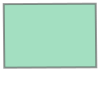

POLYGON Z ((6.918001888553011 46.455134123058194 741.45, 6.917915284967417 46.4641294511494 741.45, 6.930932993286067 46.46418865191405 1211.56, 6.931017435883795 46.45519331400965 1211.56, 6.918001888553011 46.455134123058194 741.45))


Map(center=[46.45966150948135, 6.9244668994876495], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [4]:
import pyproj
import IPython.display
import ipyleaflet
from ipyleaflet import Map, WKTLayer
from shapely.ops import transform
wsg84 = 'epsg:4326'
ch1903plus= 'epsg:2056'
project  = pyproj.Transformer.from_crs(ch1903plus, wsg84, always_xy=True).transform
wsg84_bbox_poly=transform(project, bbox_poly)
IPython.display.display(wsg84_bbox_poly)
print(wsg84_bbox_poly.wkt)
m = ipyleaflet.Map(center=(wsg84_bbox_poly.centroid.y, wsg84_bbox_poly.centroid.x), zoom=14)
wlayer = WKTLayer( wkt_string=wsg84_bbox_poly.wkt,)
m.add_layer(wlayer)
m

Nous voyons donc ci-dessus l'emrpise du nuage de points. De manière plus précise, c'est l'emprise rectangulaire définie par les coordonnées minimales et maximales des points.

# Extraction des points

Nous souhaitons traiter une zone en particulier. Je vous propose de saisir cette zone via l'outil **Draw a polygon** un polygone de la zone à extraire.

In [5]:
from pyproj import Transformer
m = ipyleaflet.Map(center=(wsg84_bbox_poly.centroid.y, wsg84_bbox_poly.centroid.x), zoom=16)
wlayer = WKTLayer( wkt_string=wsg84_bbox_poly.wkt,)
m.add_layer(wlayer)
dc = ipyleaflet.DrawControl()
m.add_control(dc)
m

Map(center=[46.45966150948135, 6.9244668994876495], controls=(ZoomControl(options=['position', 'zoom_in_text',…

Une fois le polygone tracé avec l'outil polygone, exécuter la cellule suivante.

POLYGON ((2560569.883484161 1145411.8952750408, 2560672.217101223 1145306.5050744952, 2560539.90193917 1145233.3344245784, 2560435.3744319608 1145320.3986530888, 2560569.883484161 1145411.8952750408))


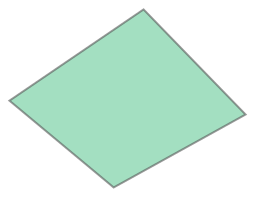

In [6]:
from pyproj import transformer
import shapely
transformer = Transformer.from_crs(wsg84, ch1903plus)
coords_draw = [transformer.transform(y,x) for (x,y) in dc.last_draw['geometry']['coordinates'][0]]
polygon_draw = shapely.geometry.Polygon(coords_draw)
print(polygon_draw.wkt)
IPython.display.display(polygon_draw)

Ci-dessus, le polygone que nous avons dessiné.

In [7]:
print(polygon_draw.bounds)

(2560435.3744319608, 1145233.3344245784, 2560672.217101223, 1145411.8952750408)


Via PDAL, nous allons **filtrer** les points du nuage d'origine en fonction du poylgone que nous venons de déterminer.

In [8]:
import pdal
polygon_draw_bounds = polygon_draw.bounds
cropper = {
    "pipeline": [str(datasource/file),
        {   "type":"filters.crop",
            'bounds':str(([polygon_draw_bounds[0], polygon_draw_bounds[2]],[polygon_draw_bounds[1], polygon_draw_bounds[3]]))},
        {   "type":"filters.crop",
            'polygon':polygon_draw.wkt
        },
        {   "type":"writers.las",
            "filename": str(output)+"\\"+"cloud_crop.laz"
        },
    ]}
pipeline = pdal.Pipeline(json.dumps(cropper))
#pipeline.validate()
%time n_points = pipeline.execute()

print('Pipeline selected {} points ({:.1f} pts/m2)'.format(n_points, n_points/polygon_draw.area))

CPU times: total: 7.52 s
Wall time: 7.63 s
Pipeline selected 800150 points (37.5 pts/m2)


# Visualisation

Nous allons visualiser les points extraits via **Ipyvolume**.

In [9]:
import ipyvolume.pylab as p3
import pandas as pd
# Load Pipeline output in python objects
arr = pipeline.arrays[0]
description = arr.dtype.descr
cols = [col for col, __ in description]
df = pd.DataFrame({col: arr[col] for col in cols})
df['X_0'] = df['X']
df['Y_0'] = df['Y']
df['Z_0'] = df['Z']
df['X'] = df['X'] - df['X_0'].min()
df['Y'] = df['Y'] - df['Y_0'].min()
df['Z'] = df['Z'] - df['Z_0'].min()

In [22]:
fig = p3.figure(width=950)
fig.xlabel='Y'
fig.ylabel='Z'
fig.zlabel='X'
all_points = p3.scatter(df['Y'], df['Z'], df['X'], color='red', size=.08,marker='box')
p3.squarelim()
p3.show()

In [23]:
import scipy
# Color ground in grey
df['ground'] = df['Classification']==2
ground = p3.scatter(df.loc[df['ground'],'Y'].values, df.loc[df['ground'],'Z'].values, df.loc[df['ground'],'X'].values, color='red', size=.9)
non_ground = p3.scatter(df.loc[~df['ground'],'Y'].values, df.loc[~df['ground'],'Z'].values, df.loc[~df['ground'],'X'].values, color='red', size=.1)
fig.scatters.append(ground)
fig.scatters.append(non_ground)
all_points.visible = False
ground.color='lightgrey'
# Show ground as surface
ground_delaunay = scipy.spatial.Delaunay(df.loc[df['ground'],['X','Y']])
ground_surf = p3.plot_trisurf(df.loc[df['ground'],'Y'], df.loc[df['ground'],'Z'], df.loc[df['ground'],'X'], ground_delaunay.simplices, color='lightgrey')
fig.meshes.append(ground_surf)
ground.visible=False



In [24]:
non_ground.visible=False
all_points.visible =False
ground.visible=False


Travaille du rendu pour que celà soit plus compréhensible. On crée une surface avec les points "groud" puis ces points sont supprimés.